In [1]:
import copy
from argparse import Namespace
import numpy as np
import matplotlib.pyplot as plt

from bax.models.simple_gp import SimpleGp
from bax.alg.algorithms import Dijkstras
from bax.acq.acqoptimize import AcqOptimizer

from typing import List
from bax.util.graph import Vertex, make_vertices, make_edges, farthest_pair, edges_of_path, positions_of_path

import neatplot
neatplot.set_style('fonts')

In [2]:
# Set random seed
seed = 0
np.random.seed(seed)

In [3]:
def softplus(x):
    return np.log1p(np.exp(x))

def inv_softplus(x):
    return np.log(np.exp(x) - 1)

In [4]:
def rosenbrock(x, y, a=1, b=100):
    return 1e-2 * ((a - x)**2 + b * (y - x**2)**2)
# min cost path: 1.0527267184880365

In [5]:
# make a grid

g = 10
#x1, x2 = np.meshgrid(np.linspace(-1, 1, g), np.linspace(-1, 1, g))
x1, x2 = np.meshgrid(np.linspace(-2, 2, g), np.linspace(-1, 4, g))
positions = np.stack([x1.flatten(), x2.flatten()], axis=-1)
n = len(positions)

has_edge = [[False for _ in range(n)] for _ in range(n)]
for i in range(n):
    for j in range(i + 1, n):
        if ((abs(i - j) == 1) and (j % g != 0)): # neighbors cardinal directions
            has_edge[i][j] = True
        elif (abs(i - j) == g): # vertices on the edge of grid
            has_edge[i][j] = True
        elif (abs(j - i) == g + 1) and (j % g != 0): # diagonals
            has_edge[i][j] = True
        elif (abs(j - i) == g - 1) and (i % g != 0): # diagonals
            has_edge[i][j] = True
        else:
            has_edge[i][j] = False
has_edge = np.array(has_edge)

In [6]:
def grid_to_array(*components):
    return np.stack([c.flatten() for c in components], axis=-1)

def array_to_grid(arr):
    # assumes arr contains points on a grid in last-dim-major order
    assert arr.ndim == 2
    n, d = arr.shape
    grid_size = int(n ** (1/d))
    components = tuple(arr.T)
    return tuple(c.reshape(*(grid_size for _ in range(d))) for c in components)

In [7]:
vertices = make_vertices(positions, has_edge)

In [8]:
edges = make_edges(vertices)

In [9]:
#def l2_dist(u: Vertex, v: Vertex):
#    return np.sqrt(np.sum((u.position - v.position)**2))
#start, goal = farthest_pair(vertices, distance_func=l2_dist)

start, goal = vertices[-g], vertices[-1]
print(f"Start position: {start.position}")
print(f"Goal position: {goal.position}")

Start position: [-2.  4.]
Goal position: [2. 4.]


In [10]:
# Set function
def true_f(x_y):
    return rosenbrock(x_y[..., 0], x_y[..., 1])

def true_latent_f(x_y):
    return inv_softplus(true_f(x_y))

def cost_func(u: Vertex, v: Vertex, f, latent_f=True):
    # padding should usually be >= mlambda u, v: cost_func(u, v, f)in(f) - max(f)
    u_pos, v_pos = u.position, v.position
    #fu, fv = f(u_pos), f(v_pos)
    #return fv - fu + padding, [u_pos, v_pos], [fu, fv]
    #return abs(fv - fu), [u_pos, v_pos], [fu, fv]
    edge = (u_pos + v_pos) / 2
    edge_cost = f(edge)
    #edge_cost = true_f(edge)
    if latent_f:
        return softplus(edge_cost), [edge], [edge_cost]
    else:
        return edge_cost, [edge], [edge_cost]

# Set data for model
data = Namespace()
data.x = []
#permutations = np.random.permutation(len(positions))
#data.x = [positions[i] for i in permutations[:10]]
data.y = [true_latent_f(x) for x in data.x]

# Set model as a GP
gp_params = {'ls': 1.0, 'alpha': 1.0, 'sigma': 1e-2}
model = SimpleGp(gp_params)
model.set_data(data)

# Set algorithm
algo = Dijkstras({
    'start': start,
    'goal': goal,
    'vertices': vertices,
    #'cost_func': lambda u, v, f: cost_func(u, v, true_latent_f, latent_f=True),
    'cost_func': lambda u, v, f: cost_func(u, v, f, latent_f=True),
    'true_cost': lambda u, v: cost_func(u, v, true_f, latent_f=False)})

#x_test = positions # input points to maximize acquisition function over

*[INFO] SimpleGp with params=Namespace(alpha=1.0, kernel=<function kern_exp_quad at 0x7f6caf1df430>, ls=1.0, name='SimpleGp', sigma=0.01)
*[INFO] Dijkstras with params=Namespace(cost_func=<function <lambda> at 0x7f6c807db1f0>, goal=(99, [88, 89, 98]), name='Dijkstras', start=(90, [80, 81, 91]), true_cost=<function <lambda> at 0x7f6c807db280>, vertices=[(0, [1, 10, 11]), (1, [0, 2, 10, 11, 12]), (2, [1, 3, 11, 12, 13]), (3, [2, 4, 12, 13, 14]), (4, [3, 5, 13, 14, 15]), (5, [4, 6, 14, 15, 16]), (6, [5, 7, 15, 16, 17]), (7, [6, 8, 16, 17, 18]), (8, [7, 9, 17, 18, 19]), (9, [8, 18, 19]), (10, [0, 1, 11, 20, 21]), (11, [0, 1, 2, 10, 12, 20, 21, 22]), (12, [1, 2, 3, 11, 13, 21, 22, 23]), (13, [2, 3, 4, 12, 14, 22, 23, 24]), (14, [3, 4, 5, 13, 15, 23, 24, 25]), (15, [4, 5, 6, 14, 16, 24, 25, 26]), (16, [5, 6, 7, 15, 17, 25, 26, 27]), (17, [6, 7, 8, 16, 18, 26, 27, 28]), (18, [7, 8, 9, 17, 19, 27, 28, 29]), (19, [8, 9, 18, 28, 29]), (20, [10, 11, 21, 30, 31]), (21, [10, 11, 12, 20, 22, 30, 31,

In [18]:
from matplotlib.collections import LineCollection as LC

def cost_of_path(path, cost_func):
    cost = 0
    for i in range(len(path) - 1):
        cost += cost_func(path[i], path[i+1])[0]
    return cost

def plot_path(ax, path, path_color=(0, 0, 0, 1.), linewidths=2, linestyle="dotted", plot_vertices=False):
    # plot path taken
    path_lines = edges_of_path(path)
    path_lc = LC(path_lines, colors=[path_color] * len(path_lines), linewidths=linewidths, linestyle=linestyle)
    ax.add_collection(path_lc)
    
    # plot visited vertices
    if plot_vertices:
        ax.scatter(*positions_of_path(path).T, color=(0, 0, 0, 1))
    return

def plot_vertices(ax, vertices):
    ax.scatter(*positions_of_path(vertices).T, color=(0, 0, 0, 1))
    return

def plot_graph(ax, edges, start: Vertex, goal: Vertex):
    # plot edges
    color = (0.75, 0.75, 0.75, 0.1)
    lc = LC(edges, colors=[color] * len(edges), linewidths=1.0)
    ax.add_collection(lc)

    # plot vertices
    ax.scatter(*positions.T, color=(0, 0, 0, 1), facecolors='none')

    # plot start and goal vertices
    ax.scatter(*start.position, color='g', label="Start", s=100)
    ax.scatter(*goal.position, color='r', label="Goal", s=100)
    
    ax.grid(False)
    ax.legend()
    return

def plot_progress(edges, start: Vertex, goal: Vertex, path: List[Vertex], plot_vertices=False):
    fig, ax = plt.subplots(figsize=(4, 4))
    
    x, y = np.meshgrid(np.linspace(-2, 2, 30), np.linspace(-1, 4, 30))
    
    # plot cost function
    cs = ax.contourf(x, y, rosenbrock(x, y), cmap='BuGn')
    cbar = fig.colorbar(cs)
    
    plot_graph(ax, edges, start, goal)
    #plot_path(ax, path, plot_vertices=plot_vertices)
    ax.set(ylim=[-1.2, 4.2], xlim=[-2.2, 2.2])
    return fig, ax

*[INFO] AcqOptimizer with params=Namespace(acq_str='exe', n_path=10, name='AcqOptimizer', opt_str='rs', parallel=False, viz_acq=False)
Found goal after visiting 99 vertices with estimated cost 12.582184997883731
Found goal after visiting 75 vertices with estimated cost 11.494285061886211
Found goal after visiting 100 vertices with estimated cost 13.454748441181833
Found goal after visiting 57 vertices with estimated cost 7.7593965601044035
Found goal after visiting 81 vertices with estimated cost 12.176312775969873
Found goal after visiting 36 vertices with estimated cost 6.318705446268738
Found goal after visiting 32 vertices with estimated cost 6.443844453820735
Found goal after visiting 70 vertices with estimated cost 7.605083282752064
Found goal after visiting 41 vertices with estimated cost 7.21870823999346
Found goal after visiting 71 vertices with estimated cost 8.320603828630535
*[TIME] [Sample 10 execution paths] Elapsed: 11.08 seconds
*[TIME] [Pre-compute acquisition function

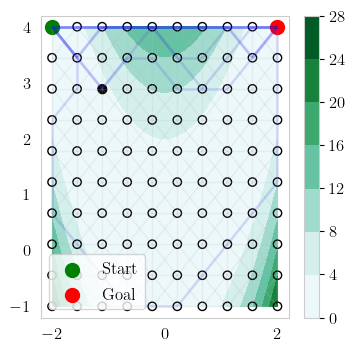

Acq optimizer x_next = (72, [61, 62, 63, 71, 73, 81, 82, 83])
Finished iter i = 0
*[INFO] AcqOptimizer with params=Namespace(acq_str='exe', n_path=10, name='AcqOptimizer', opt_str='rs', parallel=False, viz_acq=False)
Found goal after visiting 32 vertices with estimated cost 6.734387223950554
Found goal after visiting 45 vertices with estimated cost 9.791152780306
Found goal after visiting 73 vertices with estimated cost 14.864075408141447
Found goal after visiting 92 vertices with estimated cost 10.243415454211947
Found goal after visiting 83 vertices with estimated cost 12.236486540011583
Found goal after visiting 83 vertices with estimated cost 9.095208729508938
Found goal after visiting 71 vertices with estimated cost 9.821411652632044
Found goal after visiting 50 vertices with estimated cost 10.894724594747757
Found goal after visiting 29 vertices with estimated cost 8.38956569860014
Found goal after visiting 48 vertices with estimated cost 9.618122438740647
*[TIME] [Sample 10 exec

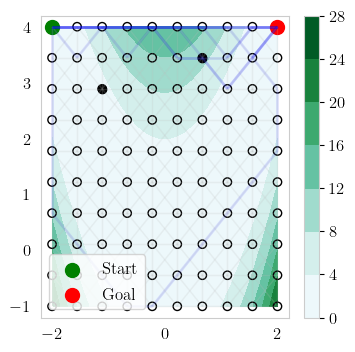

Acq optimizer x_next = (86, [75, 76, 77, 85, 87, 95, 96, 97])
Finished iter i = 1
*[INFO] AcqOptimizer with params=Namespace(acq_str='exe', n_path=10, name='AcqOptimizer', opt_str='rs', parallel=False, viz_acq=False)
Found goal after visiting 97 vertices with estimated cost 29.09159650254769
Found goal after visiting 95 vertices with estimated cost 19.408977943112205
Found goal after visiting 99 vertices with estimated cost 30.710178256142445
Found goal after visiting 95 vertices with estimated cost 21.669045605659047
Found goal after visiting 97 vertices with estimated cost 26.43825758767599
Found goal after visiting 94 vertices with estimated cost 17.133083165774742
Found goal after visiting 98 vertices with estimated cost 28.023929189252467
Found goal after visiting 94 vertices with estimated cost 17.823769941719178
Found goal after visiting 98 vertices with estimated cost 26.561221724738054
Found goal after visiting 96 vertices with estimated cost 23.511873752675612
*[TIME] [Sample

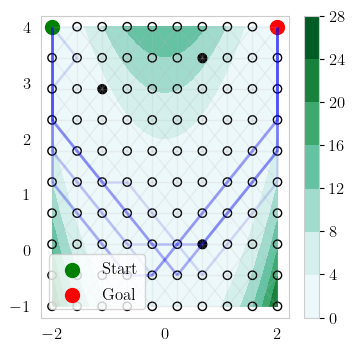

Acq optimizer x_next = (26, [15, 16, 17, 25, 27, 35, 36, 37])
Finished iter i = 2
*[INFO] AcqOptimizer with params=Namespace(acq_str='exe', n_path=10, name='AcqOptimizer', opt_str='rs', parallel=False, viz_acq=False)
Found goal after visiting 95 vertices with estimated cost 20.27835172911788
Found goal after visiting 95 vertices with estimated cost 19.16769396153556
Found goal after visiting 95 vertices with estimated cost 21.040602216636543
Found goal after visiting 95 vertices with estimated cost 17.918372704154123
Found goal after visiting 95 vertices with estimated cost 20.713659245004653
Found goal after visiting 94 vertices with estimated cost 18.507557618529763
Found goal after visiting 93 vertices with estimated cost 20.56684314106071
Found goal after visiting 97 vertices with estimated cost 25.235312444205753
Found goal after visiting 97 vertices with estimated cost 28.989772672850425
Found goal after visiting 97 vertices with estimated cost 23.827265540659393
*[TIME] [Sample 

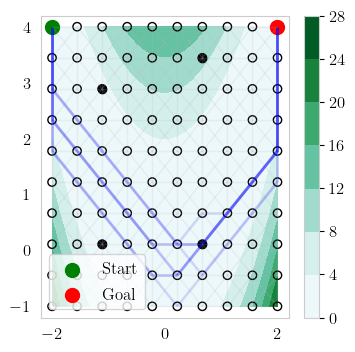

Acq optimizer x_next = (22, [11, 12, 13, 21, 23, 31, 32, 33])
Finished iter i = 3
*[INFO] AcqOptimizer with params=Namespace(acq_str='exe', n_path=10, name='AcqOptimizer', opt_str='rs', parallel=False, viz_acq=False)
Found goal after visiting 97 vertices with estimated cost 23.887690666883593
Found goal after visiting 92 vertices with estimated cost 16.924517114711815
Found goal after visiting 98 vertices with estimated cost 29.405203490488766
Found goal after visiting 92 vertices with estimated cost 15.848225811185088
Found goal after visiting 97 vertices with estimated cost 22.70187969244084
Found goal after visiting 94 vertices with estimated cost 16.256484941716188
Found goal after visiting 98 vertices with estimated cost 27.46505615275389
Found goal after visiting 94 vertices with estimated cost 20.990211544262536
Found goal after visiting 98 vertices with estimated cost 27.14117090482018
Found goal after visiting 96 vertices with estimated cost 23.94252577852295
*[TIME] [Sample 1

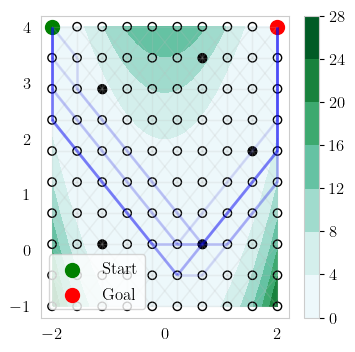

Acq optimizer x_next = (58, [47, 48, 49, 57, 59, 67, 68, 69])
Finished iter i = 4
*[INFO] AcqOptimizer with params=Namespace(acq_str='exe', n_path=10, name='AcqOptimizer', opt_str='rs', parallel=False, viz_acq=False)
Found goal after visiting 94 vertices with estimated cost 15.667790097423328
Found goal after visiting 91 vertices with estimated cost 15.831942134950284
Found goal after visiting 91 vertices with estimated cost 12.284221295613147
Found goal after visiting 95 vertices with estimated cost 20.598557723039793
Found goal after visiting 96 vertices with estimated cost 23.012868659108584
Found goal after visiting 95 vertices with estimated cost 17.02928081871515
Found goal after visiting 94 vertices with estimated cost 15.575625269973855
Found goal after visiting 93 vertices with estimated cost 16.34952379779818
Found goal after visiting 94 vertices with estimated cost 19.629742183582753
Found goal after visiting 91 vertices with estimated cost 13.790394062362507
*[TIME] [Sample

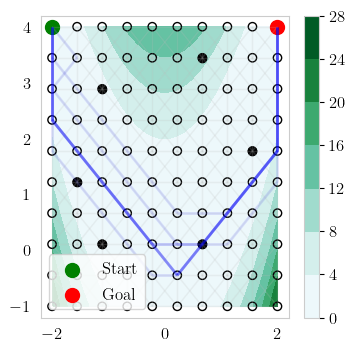

Acq optimizer x_next = (41, [30, 31, 32, 40, 42, 50, 51, 52])
Finished iter i = 5
*[INFO] AcqOptimizer with params=Namespace(acq_str='exe', n_path=10, name='AcqOptimizer', opt_str='rs', parallel=False, viz_acq=False)
Found goal after visiting 96 vertices with estimated cost 18.99977558781766
Found goal after visiting 95 vertices with estimated cost 18.276204093373632
Found goal after visiting 96 vertices with estimated cost 18.638258294466638
Found goal after visiting 95 vertices with estimated cost 19.714496104074225
Found goal after visiting 93 vertices with estimated cost 17.071635013747063
Found goal after visiting 94 vertices with estimated cost 15.495457935223065
Found goal after visiting 95 vertices with estimated cost 17.089120198382247
Found goal after visiting 91 vertices with estimated cost 15.708580242835259
Found goal after visiting 91 vertices with estimated cost 13.493929940842444
Found goal after visiting 96 vertices with estimated cost 22.721788232397657
*[TIME] [Sampl

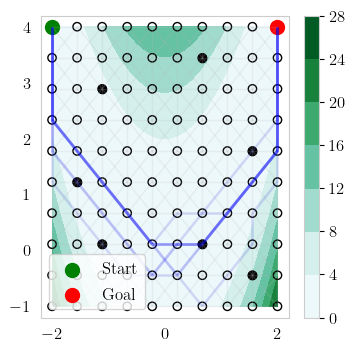

Acq optimizer x_next = (18, [7, 8, 9, 17, 19, 27, 28, 29])
Finished iter i = 6
*[INFO] AcqOptimizer with params=Namespace(acq_str='exe', n_path=10, name='AcqOptimizer', opt_str='rs', parallel=False, viz_acq=False)
Found goal after visiting 94 vertices with estimated cost 17.46408598233537
Found goal after visiting 94 vertices with estimated cost 16.041446575843793
Found goal after visiting 88 vertices with estimated cost 12.712722157862821
Found goal after visiting 89 vertices with estimated cost 14.649120405242169
Found goal after visiting 89 vertices with estimated cost 13.316328540250804
Found goal after visiting 87 vertices with estimated cost 13.044439774512663
Found goal after visiting 94 vertices with estimated cost 19.100290147297137
Found goal after visiting 88 vertices with estimated cost 14.676845999282968
Found goal after visiting 89 vertices with estimated cost 14.787525948838177
Found goal after visiting 93 vertices with estimated cost 19.49501882760408
*[TIME] [Sample 10

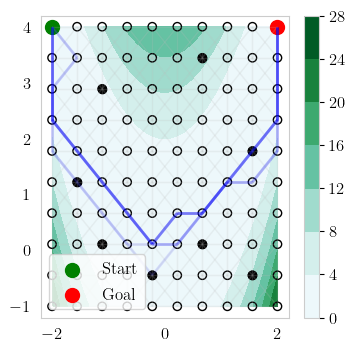

Acq optimizer x_next = (14, [3, 4, 5, 13, 15, 23, 24, 25])
Finished iter i = 7
*[INFO] AcqOptimizer with params=Namespace(acq_str='exe', n_path=10, name='AcqOptimizer', opt_str='rs', parallel=False, viz_acq=False)
Found goal after visiting 93 vertices with estimated cost 18.607350243254878
Found goal after visiting 95 vertices with estimated cost 19.594682201746863
Found goal after visiting 93 vertices with estimated cost 17.621424955518208
Found goal after visiting 92 vertices with estimated cost 15.823387669913908
Found goal after visiting 83 vertices with estimated cost 12.552391548454718
Found goal after visiting 91 vertices with estimated cost 15.509411264955318
Found goal after visiting 85 vertices with estimated cost 12.301504950100446
Found goal after visiting 92 vertices with estimated cost 16.207327297400877
Found goal after visiting 92 vertices with estimated cost 16.09532834649735
Found goal after visiting 94 vertices with estimated cost 17.96453381818231
*[TIME] [Sample 10

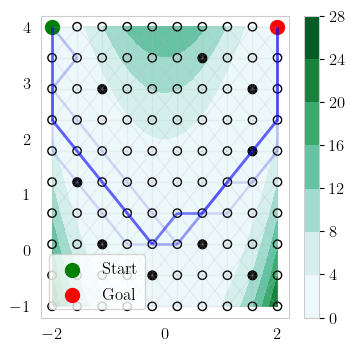

Acq optimizer x_next = (78, [67, 68, 69, 77, 79, 87, 88, 89])
Finished iter i = 8
*[INFO] AcqOptimizer with params=Namespace(acq_str='exe', n_path=10, name='AcqOptimizer', opt_str='rs', parallel=False, viz_acq=False)
Found goal after visiting 66 vertices with estimated cost 7.746037969131433
Found goal after visiting 63 vertices with estimated cost 8.577326170160982
Found goal after visiting 70 vertices with estimated cost 7.515809853112508
Found goal after visiting 71 vertices with estimated cost 10.206080574356658
Found goal after visiting 69 vertices with estimated cost 8.808986986010815
Found goal after visiting 70 vertices with estimated cost 5.998219982707093
Found goal after visiting 68 vertices with estimated cost 10.66407560465909
Found goal after visiting 64 vertices with estimated cost 6.082998306733718
Found goal after visiting 70 vertices with estimated cost 7.566704839131218
Found goal after visiting 62 vertices with estimated cost 8.456739856948259
*[TIME] [Sample 10 exe

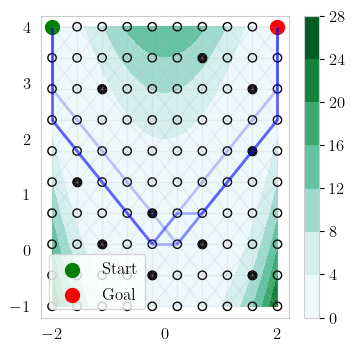

Acq optimizer x_next = (34, [23, 24, 25, 33, 35, 43, 44, 45])
Finished iter i = 9


In [13]:
plot = True
n_iter = 10

outputs_of_iter = []

#current_path = [start]
current_path = []
#current_path = [vertices[i] for i in permutations[:10]]
#x_test = possible_steps(start)
x_test = positions

for i in range(n_iter):
    # Optimize acquisition function
    acqopt = AcqOptimizer({'n_path': 10,
                           'viz_acq': False})
    arg_x_next = acqopt.optimize(model, algo, x_test, return_argmax=True)

    sampled_outputs = acqopt.get_last_output_list()
    outputs_of_iter.append(sampled_outputs)

    # Query function, update data
    x_next = x_test[arg_x_next]
    y_next = true_latent_f(x_next)
    data.x.append(x_next)
    data.y.append(y_next)

    # Update physical path taken
    next_vertex = vertices[arg_x_next]
    current_path.append(next_vertex)

    # Update model
    model = SimpleGp(gp_params)
    model.set_data(data)

    # plots
    if plot:
        fig, ax = plot_progress(edges, start, goal, current_path)
        plot_vertices(ax, current_path)

        last_outputs = acqopt.get_last_output_list()
        min_costs, min_cost_paths = zip(*last_outputs)
        n = acqopt.params.n_path
        for path in min_cost_paths:
            plot_path(ax, path, path_color=(0, 0, 1, 1/n), linewidths=2, linestyle="-")

        # make matplotlib plot within for loop. See: https://stackoverflow.com/questions/19766100/real-time-matplotlib-plot-is-not-working-while-still-in-a-loop
        plt.pause(0.0001)

    print(f'Acq optimizer x_next = {next_vertex}')
    print(f'Finished iter i = {i}')

In [17]:
outputs_of_iter[-1]

((7.746037969131433,
  [(90, [80, 81, 91]),
   (80, [70, 71, 81, 90, 91]),
   (70, [60, 61, 71, 80, 81]),
   (60, [50, 51, 61, 70, 71]),
   (51, [40, 41, 42, 50, 52, 60, 61, 62]),
   (42, [31, 32, 33, 41, 43, 51, 52, 53]),
   (33, [22, 23, 24, 32, 34, 42, 43, 44]),
   (24, [13, 14, 15, 23, 25, 33, 34, 35]),
   (25, [14, 15, 16, 24, 26, 34, 35, 36]),
   (36, [25, 26, 27, 35, 37, 45, 46, 47]),
   (47, [36, 37, 38, 46, 48, 56, 57, 58]),
   (58, [47, 48, 49, 57, 59, 67, 68, 69]),
   (69, [58, 59, 68, 78, 79]),
   (79, [68, 69, 78, 88, 89]),
   (89, [78, 79, 88, 98, 99]),
   (99, [88, 89, 98])]),
 (8.577326170160982,
  [(90, [80, 81, 91]),
   (80, [70, 71, 81, 90, 91]),
   (70, [60, 61, 71, 80, 81]),
   (60, [50, 51, 61, 70, 71]),
   (51, [40, 41, 42, 50, 52, 60, 61, 62]),
   (42, [31, 32, 33, 41, 43, 51, 52, 53]),
   (33, [22, 23, 24, 32, 34, 42, 43, 44]),
   (24, [13, 14, 15, 23, 25, 33, 34, 35]),
   (35, [24, 25, 26, 34, 36, 44, 45, 46]),
   (36, [25, 26, 27, 35, 37, 45, 46, 47]),
   (47

In [28]:
[(output[0], cost_of_path(output[1], algo.params.true_cost)) for output in outputs_of_iter[-1]]

[(7.746037969131433, 8.6390626428898),
 (8.577326170160982, 8.961422039323272),
 (7.515809853112508, 6.921243712848649),
 (10.206080574356658, 6.841243712848647),
 (8.808986986010815, 8.6390626428898),
 (5.998219982707093, 6.921243712848649),
 (10.66407560465909, 6.841243712848647),
 (6.082998306733718, 8.961422039323272),
 (7.566704839131218, 8.6390626428898),
 (8.456739856948259, 8.961422039323272)]